In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage import feature
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
from tqdm import tqdm

In [3]:
# Define dataset paths
original_path = "First Print"
counterfeit_path = "Second Print"

def load_images(folder_path, label):
    images = []
    labels = []
    for file in os.listdir(folder_path):
        img_path = os.path.join(folder_path, file)
        image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        if image is not None:
            images.append(image)
            labels.append(label)
    return images, labels

# Load images from both classes
original_images, original_labels = load_images(original_path, 0)
counterfeit_images, counterfeit_labels = load_images(counterfeit_path, 1)

# Combine datasets
images = original_images + counterfeit_images
labels = original_labels + counterfeit_labels

In [8]:
# Feature extraction function
def extract_features(image):
    radius = 3
    n_points = 8 * radius
    lbp = feature.local_binary_pattern(image, n_points, radius, method='uniform')
    lbp_hist, _ = np.histogram(lbp.ravel(), bins=np.arange(0, n_points + 3), density=True)
    
    glcm = feature.graycomatrix(image, distances=[1], angles=[0], levels=256, symmetric=True, normed=True)
    contrast = feature.graycoprops(glcm, 'contrast')[0, 0]
    dissimilarity = feature.graycoprops(glcm, 'dissimilarity')[0, 0]
    homogeneity = feature.graycoprops(glcm, 'homogeneity')[0, 0]
    energy = feature.graycoprops(glcm, 'energy')[0, 0]
    correlation = feature.graycoprops(glcm, 'correlation')[0, 0]
    
    noise = image - cv2.GaussianBlur(image, (5, 5), 0)
    noise_std = np.std(noise)
    
    edges = cv2.Canny(image, 100, 200)
    edge_density = np.sum(edges) / (image.shape[0] * image.shape[1])
    
    return np.hstack([lbp_hist, contrast, dissimilarity, homogeneity, energy, correlation, noise_std, edge_density])

# Extract features for all images
features = np.array([extract_features(img) for img in tqdm(images, desc="Extracting Features")])
labels = np.array(labels)

Extracting Features: 100%|██████████| 200/200 [01:29<00:00,  2.25it/s]


In [9]:
# Split dataset into training and testing
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)

# Train models
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

svm_model = SVC(kernel='linear', probability=True)
svm_model.fit(X_train, y_train)

SVC(kernel='linear', probability=True)


Evaluation for Random Forest
              precision    recall  f1-score   support

           0       1.00      0.90      0.95        21
           1       0.90      1.00      0.95        19

    accuracy                           0.95        40
   macro avg       0.95      0.95      0.95        40
weighted avg       0.95      0.95      0.95        40



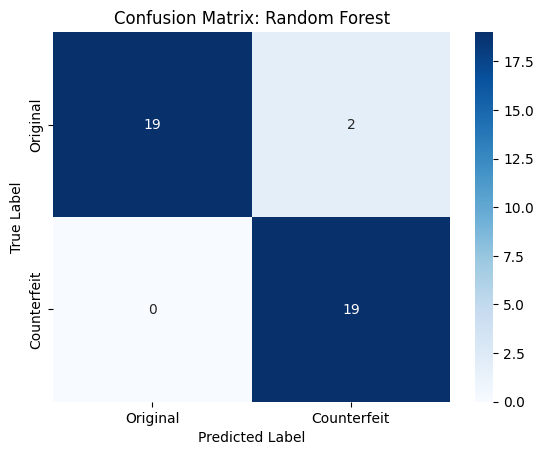


Evaluation for SVM
              precision    recall  f1-score   support

           0       0.70      0.67      0.68        21
           1       0.65      0.68      0.67        19

    accuracy                           0.68        40
   macro avg       0.68      0.68      0.67        40
weighted avg       0.68      0.68      0.68        40



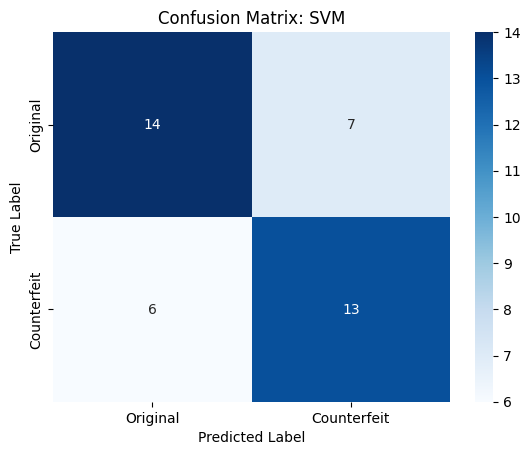

In [10]:
# Predictions
rf_predictions = rf_model.predict(X_test)
svm_predictions = svm_model.predict(X_test)

# Evaluate models
def evaluate_model(predictions, model_name):
    print(f"\nEvaluation for {model_name}")
    print(classification_report(y_test, predictions))
    cm = confusion_matrix(y_test, predictions)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Original', 'Counterfeit'], yticklabels=['Original', 'Counterfeit'])
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title(f'Confusion Matrix: {model_name}')
    plt.show()

evaluate_model(rf_predictions, "Random Forest")
evaluate_model(svm_predictions, "SVM")